In [1]:
from google.colab import files
# drive.mount('/content/drive')
upload=files.upload()
#

Saving Fruit.v1i.folder.zip to Fruit.v1i.folder.zip


In [2]:
# Change path if your zip file name is different
zip_path = "/content/Fruit.v1i.folder.zip"

!unzip -q "$zip_path" -d /content/fruit_dataset


In [5]:
import os

train_dir = "/content/fruit_dataset/train"
classes = sorted(os.listdir(train_dir))
print("Classes:", classes)
print("Total Classes:", len(classes))


Classes: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Total Classes: 10


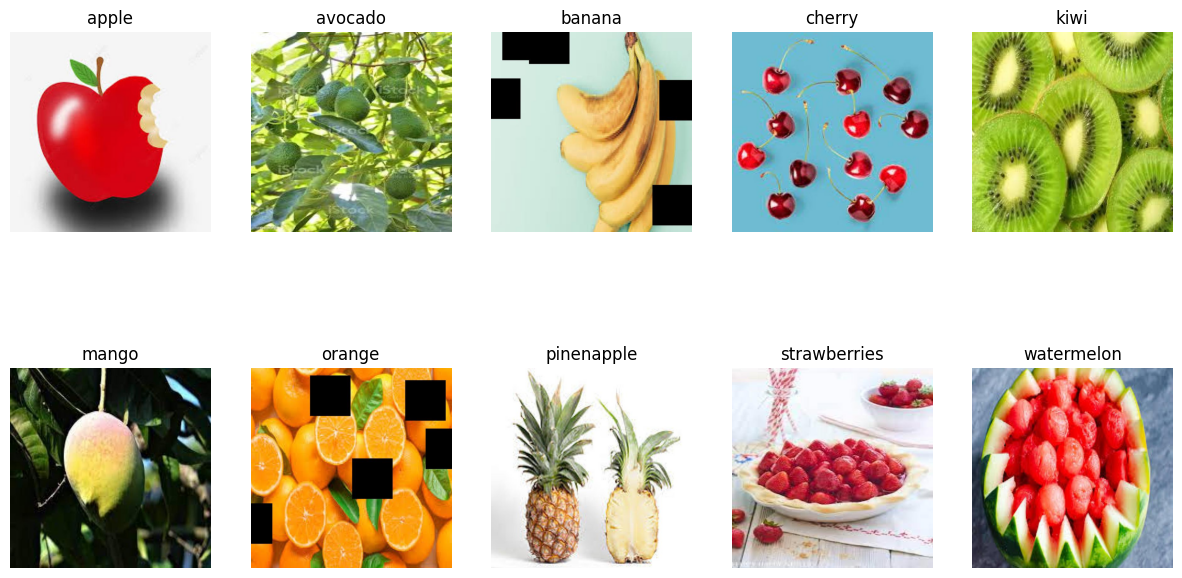

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.show()


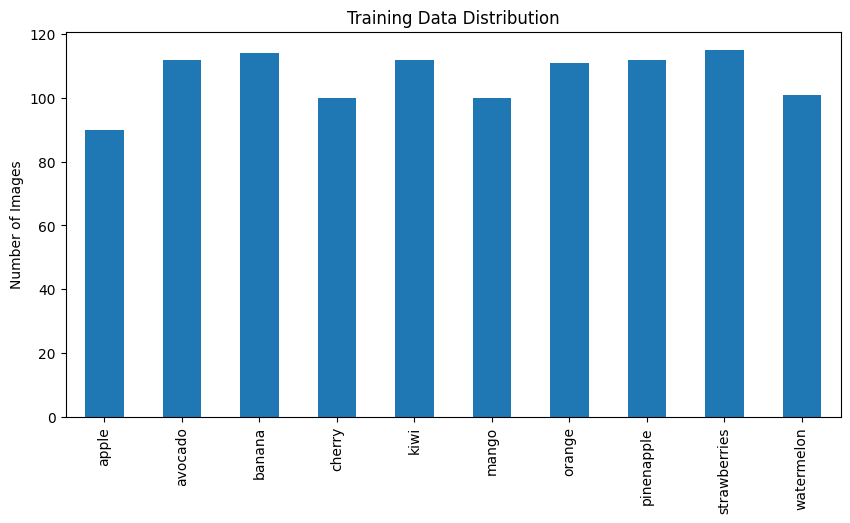

In [9]:
import pandas as pd

counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

pd.Series(counts).plot(kind='bar', figsize=(10,5), title="Training Data Distribution")
plt.ylabel("Number of Images")
plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_data = valid_gen.flow_from_directory(
    "/content/fruit_dataset/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    "/content/fruit_dataset/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1067 images belonging to 10 classes.
Found 205 images belonging to 10 classes.
Found 102 images belonging to 10 classes.


# **Model Development**

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [15]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [24]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9353 - loss: 0.2051 - val_accuracy: 0.6537 - val_loss: 3.9950
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9202 - loss: 0.3550 - val_accuracy: 0.6293 - val_loss: 4.6378
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9110 - loss: 0.3541 - val_accuracy: 0.6732 - val_loss: 4.7890
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9272 - loss: 0.2617 - val_accuracy: 0.6293 - val_loss: 5.8151


# **Fine Tuning**

In [25]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=5
)


Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9044 - loss: 0.3520 - val_accuracy: 0.6927 - val_loss: 3.4021
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9286 - loss: 0.2309 - val_accuracy: 0.7122 - val_loss: 2.9352
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9529 - loss: 0.1772 - val_accuracy: 0.7366 - val_loss: 2.5900
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9395 - loss: 0.2055 - val_accuracy: 0.7659 - val_loss: 2.3087
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9478 - loss: 0.1557 - val_accuracy: 0.7805 - val_loss: 2.0653


In [32]:
import numpy as np

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [52]:
from sklearn.metrics import classification_report

print(classification_report(
    test_data.classes,
    y_pred_classes,
    target_names=classes
))


              precision    recall  f1-score   support

       apple       0.52      1.00      0.69        11
     avocado       1.00      0.83      0.91        12
      banana       1.00      0.50      0.67        12
      cherry       0.83      0.83      0.83         6
        kiwi       1.00      1.00      1.00         8
       mango       0.86      0.67      0.75         9
      orange       0.75      0.82      0.78        11
  pinenapple       0.89      0.80      0.84        10
strawberries       0.67      0.75      0.71         8
  watermelon       0.71      0.67      0.69        15

    accuracy                           0.77       102
   macro avg       0.82      0.79      0.79       102
weighted avg       0.82      0.77      0.78       102



Training Curves

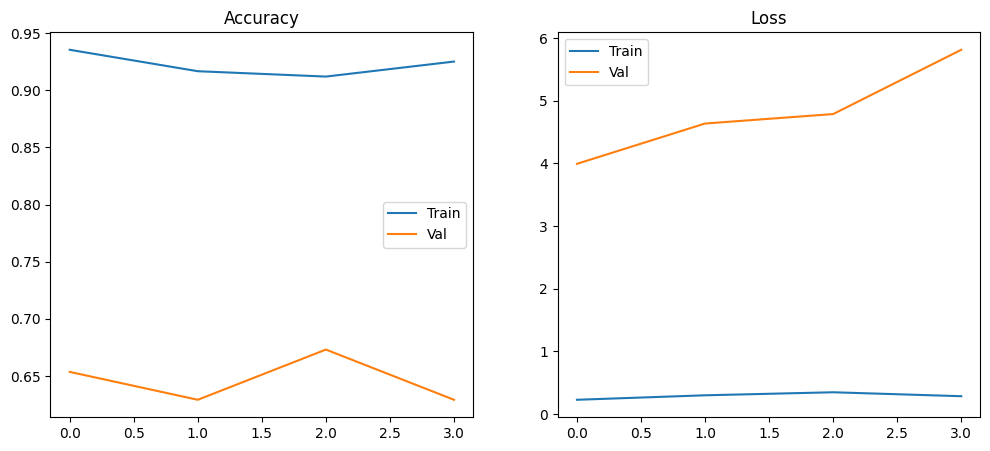

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()


Confusion Matrix

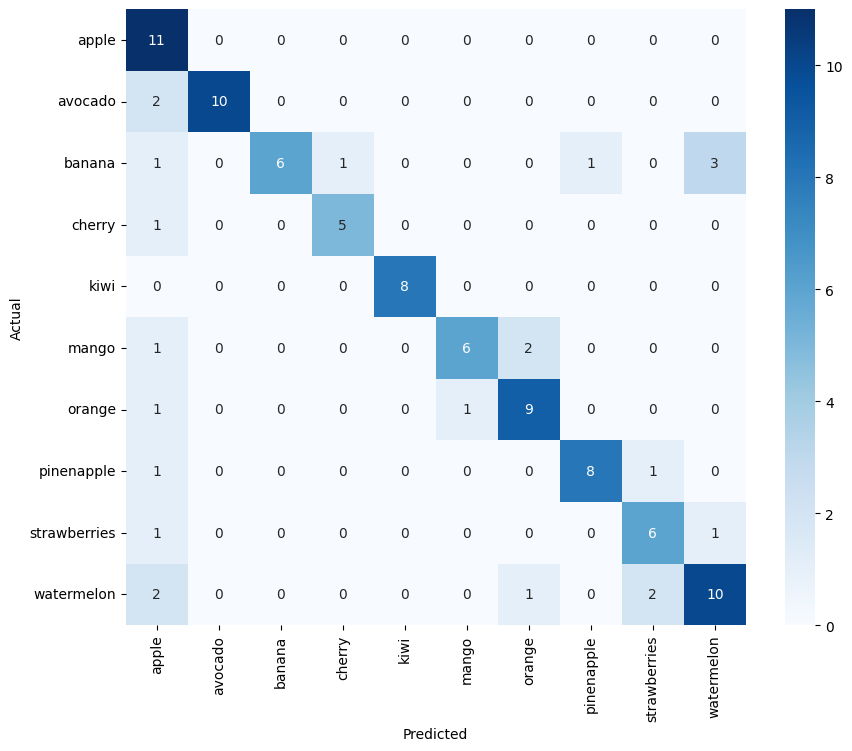

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_data.classes, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes,yticklabels=classes,cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Error Analysis


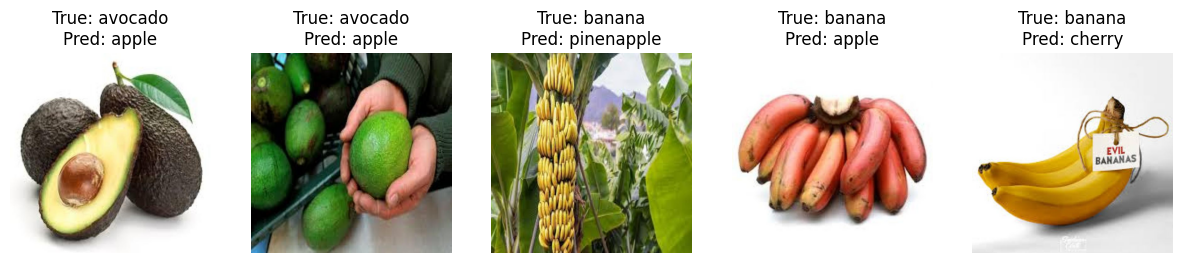

In [35]:
errors = np.where(y_pred_classes != test_data.classes)[0]

plt.figure(figsize=(15,5))
for i, idx in enumerate(errors[:5]):
    img = Image.open(test_data.filepaths[idx])
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"True: {classes[test_data.classes[idx]]}\nPred: {classes[y_pred_classes[idx]]}")
    plt.axis('off')

plt.show()


Model confused between Apple and avocado due to similar shape and about bananas i don't know.

# Deployment

In [42]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_fruit(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_index = np.argmax(preds)
    confidence = preds[0][class_index]

    predicted_class = classes[class_index]
    print(f"Predicted Fruit: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

    return predicted_class, confidence


In [44]:
predict_fruit('/content/sample_data/close-up-delicious-apple_23-2151868338.avif')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Fruit: apple
Confidence: 1.00


('apple', np.float32(1.0))

# **Summary**

This project built a fruit classification model using transfer learning. The model achieved good accuracy by using a pre-trained network and data augmentation. Some errors occurred between similar-looking fruits, but overall the approach worked well and can be improved further with more data or deeper models